In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Castelijns, Laurens (1095926)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

The model has 3 dense layers with 128, 64, and 32 nodes. The model proved to be too 'narrow' with less nodes per layer. Switching from the rmsprop optimizer to a sgd optimizer resulted in a big performance increase (from ~60% to ~80%), possibly the rmsprop optimizer was taking too big steps with its default settings. This model achieved 81.4% accuracy, for a simple model it performs reasonably well.  (length: 404)



Max val score: 81.38%


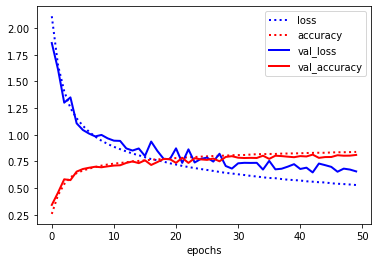

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_40 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_231 (Dense)            (None, 128)               393344    
_________________________________________________________________
dense_232 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_233 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_234 (Dense)            (None, 10)                330       
Total params: 404,010
Trainable params: 404,010
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32

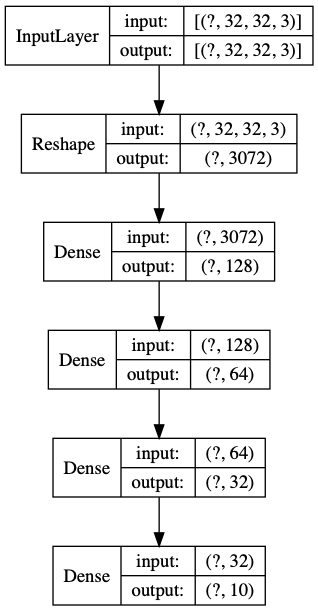

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

The training data and validation data are converted to grayscale using the helper function. This reduces the data from a 4D tensor to a 3D tensor. The input shape needs to reflect this, it is now 32*32 and flattened to a vector with length 1024. The model ends up having a very similar performance to the model from question 1.1 yet it trains faster because it has significantly less parameters to learn. Therefore, this model is slightly better.  (length: 448)



Max val score: 81.20%


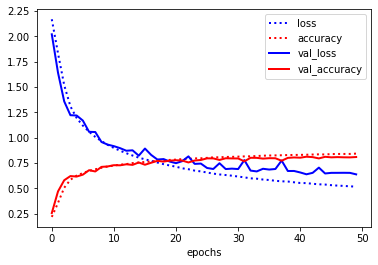

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_46 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_255 (Dense)            (None, 128)               131200    
_________________________________________________________________
dense_256 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_257 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_258 (Dense)            (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32)))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

Applying and tuning L2 regularization lead to the model converging quicker, but also overfitting quite heavily. To remedy this, I added dropout layers with an incremental increase in dropout rate. I am using small dropout rates because larger dropout rates lead to the model not converging. Finally, I adjusted the learning rate and momentum to squeeze out a bit more performance. This model achieved a 2 percentage point performance increase over the models from 1.1 and 1.2.  (length: 478)



Max val score: 83.46%


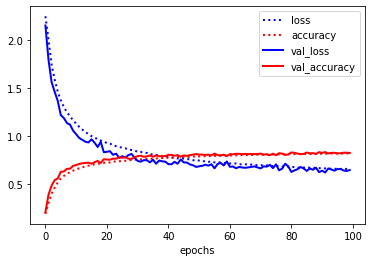

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32)))

    model.add(layers.Dense(128, kernel_regularizer=l2(0.0001), activation='relu'))
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(64, kernel_regularizer=l2(0.0001), activation='relu'))
    model.add(layers.Dropout(0.10))
    model.add(layers.Dense(32, kernel_regularizer=l2(0.0001), activation='relu'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(10, activation='softmax'))

    sgd = optimizers.SGD(learning_rate=0.005, momentum=0.5)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I use a VGG-like structure with 3 blocks of 2 stacked convolutional layers (w/ padding) and a pooling layer. The relatively large number of conv layers adds depth to the model, to keep this depth feasible I use a small kernel size of 3x3. This model converged extremely quick but was also overfitting badly. To combat this, I added dropout layers between each block with an incremental increase in dropout rate. This time I was able to pick larger dropout rates, perhaps I picked them too large because it takes a few epochs before the model starts to converge. After tuning the learning rate, decay and momentum this was still happening, but I was happy with the performance I was getting. With an accuracy of 95.5% the model performs excellent. (length: 747)



Max val score: 95.51%


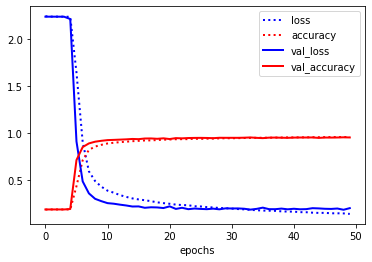

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 64)        

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (3, 3) ,padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3) ,padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    sgd = optimizers.SGD(lr=0.02, decay=1e-5, momentum=

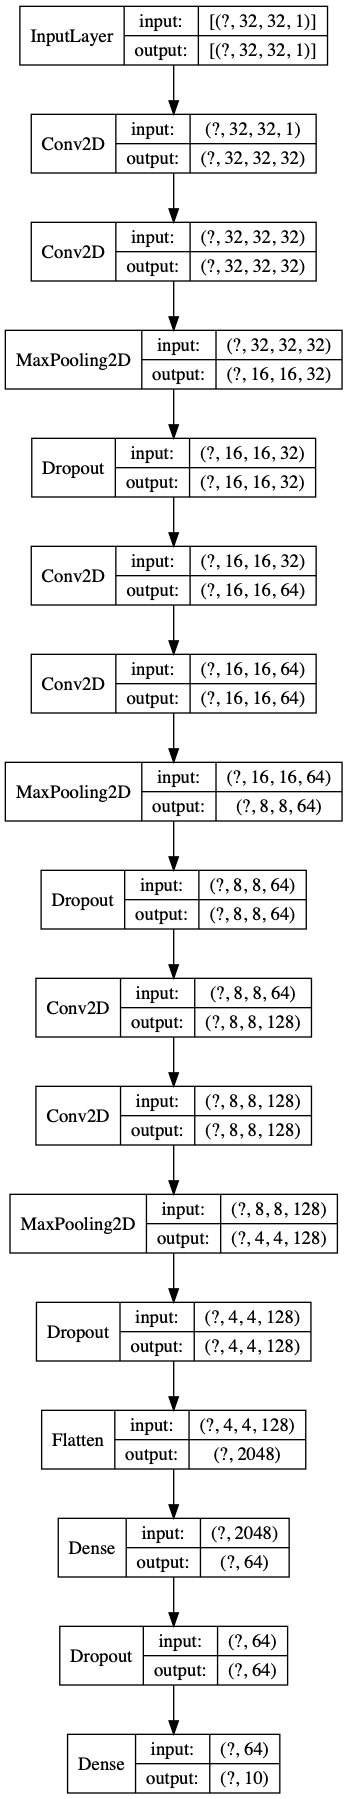

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

The dataset is very consistent, therefore, it is better to only use very subtle augmentations (such as width_shift and height_shift with small values). For example, learning the patterns of an upside down 4 is irrelevant because we never have to detect such a 4. Because the amount of data is increased I let the model run for more epochs. Using data augmentation I gained a bit of additional performance and achieved an accuracy of 96.3% on the validation set. (length: 462)



Max val score: 96.31%


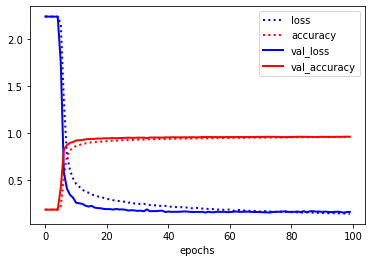


augmentations = ImageDataGenerator(
    width_shift_range=2,
    height_shift_range=3,
    zoom_range=0.05,
    rotation_range=5)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

Performance on the test set is good with 96.1%. Most of the mistakes are made in the classes 1, 3 and 7. Both a 7 and 4 are often confused for a 1, likewise a 5 is often predicted as a 4. The misclassifications are understandable when visualizing the misclassifications of class '7'. Most of these images would also be illegible to a human because of all the noise. In some cases the image is mislabeled. From the 10 images below, I only blame the model for failing to detect image #8 correctly. (length: 496)

Test score: 0.96%


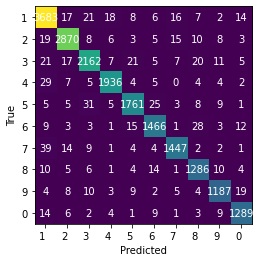

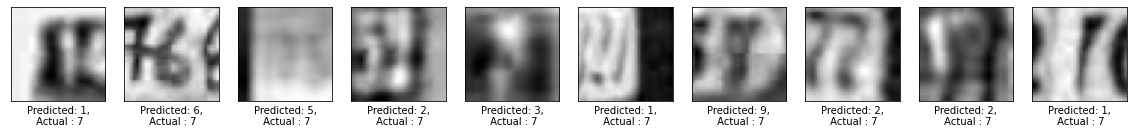

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

In the first layer most of the activations retain almost the full shape of the eight. In the second layer, we start to see activations encode borders and the 2 holes of the number eight (a distinct feature of 8 in most fonts). In the remaining interpretable layers, activations become more abstract, but the hole and edge detection is still apparent in some feature maps. The model seems to be learning something useful since I can still distinguish an eight in layer 6. (length: 471)



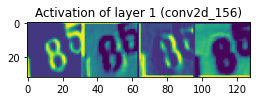

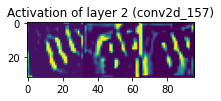

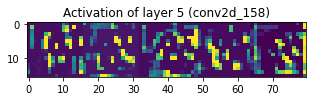

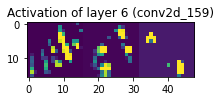

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

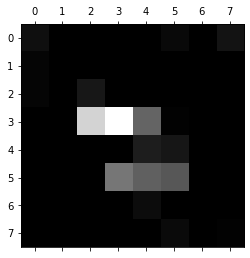

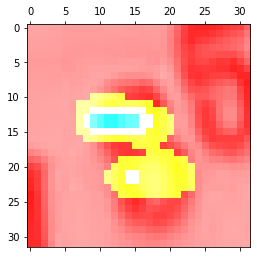

def plot_activation_map():   
    
    x = X_test_gray[0]
    x = np.expand_dims(x, axis=0)

    output = model_2_2.output[:, 7]
    last_conv_layer = model_2_2.get_layer('conv2d_161')

    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=((0, 1, 2)))
    iterate = K.function([model_2_2.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap, cmap='gray')
    plt.show()
    
    return heatmap



In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Freezing the convolutional base made the model converge very slowly and the performance was bad. Unfreezing the last block of convolutional layers was working better. To make sure that I don't unlearn too much I picked a small learning rate. However, the model is still overfitting quite badly.  (length: 296)



Max val score: 83.16%


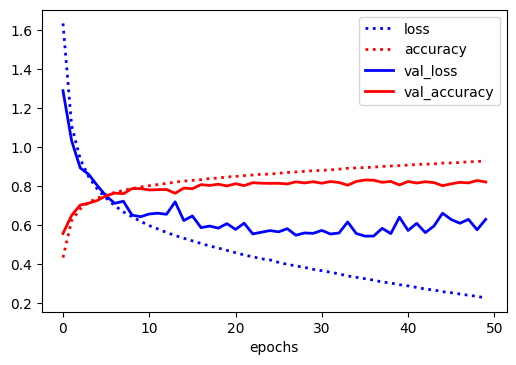

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 7,213,322
Non-trainable params: 7,635,264
_________________________________________________________________
None


def build_model_4_1():
    VGG16_base = VGG16(weights='imagenet', 
                    include_top=False,
                    input_shape=(32, 32, 3))
    
    set_trainable = False
    VGG16_base.trainable = True
    for layer in VGG16_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    model = models.Sequential()
    model.add(VGG16_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))

    sgd = optimizers.SGD(lr=1e-3)

    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



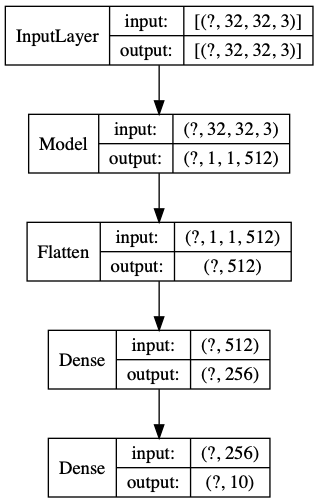

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

I experimented on the validation set with gridsearches on random forests, Knn and SVMs. To speed up the runtime of the algorithms I used PCA to reduce the dimensionality of the embeddings. Scaling before applying PCA actually reduced my accuracy. Random forests peaked at ~75% accuracy and Knn ~80%. I obtained my best accuracy of 84.5% with an SVM using gamma=0.002. The models from question 2 performed much better, but it's better than the models from question 1 and 4.1.  (length: 476)

Pipeline(steps=[('PCA', PCA(n_components=0.99)),
                ('classifier', SVC(gamma=0.002))])
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model_4_1 = load_model_from_file(base_dir, "model_4_1", extension='.h5')
    embed_model = model_4_1.layers[0]

    X_train_embed=[]
    for i in range(0, len(X_train)):
        x=np.expand_dims(X_train[i],axis=0)
        img=embed_model(x)
        X_train_embed.append(img.numpy()[0][0][0])
    store_embedding(X_train_embed

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 20.21 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
